In [1]:
import os
import pandas as pd
import sys
import argparse
import random
import math
import numpy as np

In [2]:
import argparse

parser = argparse.ArgumentParser()

parser.add_argument(
    '--synthetic_column_size',
    type=int,
    default=10,
    help='Size of synthetic column')
parser.add_argument(
    '--sequence_size',
    type=int,
    default=50,
    help='Length of word sequence of synthetic column')
parser.add_argument(
    '--model_dir',
    type=str,
    default=os.path.abspath('C:/Users/zacharias.detorakis/Desktop/city-ds-final-project/SemAIDA-master/AAAI19/exp_T2D/in_out/w2v_model/enwiki_model'),
    # default='~/w2v_model/enwiki_model/',
    help='Directory of word2vec model')
FLAGS, unparsed = parser.parse_known_args()

In [3]:
os.chdir('data')

In [4]:
def read_cls_entities(file_name):
    cls_entities = dict()
    with open(os.path.join(os.getcwd(), file_name), 'r', encoding="utf-8") as fun_f:
        for line in fun_f.readlines():
            line_tmp = line.strip().split('","')
            line_tmp[0] = line_tmp[0][1:]
            line_tmp[-1] = line_tmp[-1][:-1]
            cls_entities[line_tmp[0]] = line_tmp[1:]
    return cls_entities

def align_samples(pos, neg, pct = 0.5):
    if len(pos) <= len(neg):
        return pos+[random.choice(pos) for _ in range(math.ceil((len(neg)-len(pos))*pct))], neg
    else:
        return pos, neg+[random.choice(neg) for _ in range(math.ceil((len(pos)-len(neg))*pct))]

In [5]:
# file = os.path.join(os.getcwd(), 'particular_neg_samples.csv')
# df_target_col = pd.read_csv(file,header=None)
cls_neg_par_entities = read_cls_entities('particular_neg_samples.csv')
cls_pos_gen_entities = read_cls_entities('general_pos_samples.csv')

In [24]:
p_ents, n_ents = align_samples(cls_pos_gen_entities['GovernmentAgency'], cls_neg_par_entities['GovernmentAgency'],1)

In [25]:
print(f"len(pos): {len(p_ents)}, len(neg): {len(n_ents)}")

len(pos): 1000, len(neg): 17126


In [8]:
# n_ents[1]

In [9]:
from pattern.text.en import tokenize

def generate_synthetic_columns(entities, synthetic_column_size):
    ent_units = list()
    if len(entities) >= synthetic_column_size:
        for i, ent in enumerate(entities):
            unit = random.sample(entities[0:i] + entities[(i + 1):], synthetic_column_size - 1)
            unit.append(ent)
            ent_units.append(unit)
    else:
        unit = entities + ['NaN'] * (len(entities) - synthetic_column_size)
        ent_units.append(unit)
    return ent_units

def synthetic_columns2sequence(ent_units, sequence_size):
    word_seq = list()
    for ent in ent_units:
        ent_n = ent.replace('_', ' ').replace('-', ' ').replace('.', ' ').replace('/', ' '). \
            replace('"', ' ').replace("'", ' ')
        tokenized_line = ' '.join(tokenize(ent_n))
        is_alpha_word_line = [word for word in tokenized_line.lower().split() if word.isalpha()]
        word_seq += is_alpha_word_line
    if len(word_seq) >= sequence_size:
        return word_seq[0:sequence_size]
    else:
        return word_seq + ['NaN'] * (sequence_size - len(word_seq))
    
def sequence2matrix(word_seq, sequence_size, w2v_model):
    ent_v = np.zeros((sequence_size, w2v_model.vector_size, 1))
    for i, word in enumerate(word_seq):
        if not word == 'NaN' and word in w2v_model.wv.vocab:
            w_vec = w2v_model.wv[word]
            ent_v[i] = w_vec.reshape((w2v_model.vector_size, 1))
    return ent_v

C:\Users\zacharias.detorakis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\zacharias.detorakis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` he

In [10]:
def embedding(entities_positive, entities_negative):
    # embedding
    units_positive = generate_synthetic_columns(entities_positive, FLAGS.synthetic_column_size)
    units_negative = generate_synthetic_columns(entities_negative, FLAGS.synthetic_column_size)

    sequences_positive = list()
    for ent_unit in units_positive:
        sequences_positive.append(synthetic_columns2sequence(ent_unit, FLAGS.sequence_size))
    sequences_negative = list()
    for ent_unit in units_negative:
        sequences_negative.append(synthetic_columns2sequence(ent_unit, FLAGS.sequence_size))

    x = np.zeros((len(sequences_positive) + len(sequences_negative), FLAGS.sequence_size, w2v_model.vector_size, 1))
    for sample_i, sequence in enumerate(sequences_positive + sequences_negative):
        x[sample_i] = sequence2matrix(sequence, FLAGS.sequence_size, w2v_model)

    y_positive = np.zeros((len(sequences_positive), 2))
    y_positive[:, 1] = 1.0
    y_negative = np.zeros((len(sequences_negative), 2))
    y_negative[:, 0] = 1.0
    y = np.concatenate((y_positive, y_negative))

    # shuffling
    np.random.seed(10)
    shuffle_indices = np.random.permutation(np.arange(y.shape[0]))
    x_shuffled = x[shuffle_indices]
    y_shuffled = y[shuffle_indices]
    return x_shuffled, y_shuffled

In [11]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load(os.path.join(FLAGS.model_dir, 'word2vec_gensim'))

In [26]:
X, Y = embedding(p_ents, n_ents)

In [27]:
dev_sample_index = int(.6 * float(X.shape[0]))
print(dev_sample_index)
X_train, X_dev = X[dev_sample_index:], X[:dev_sample_index]
Y_train, Y_dev = Y[dev_sample_index:], Y[:dev_sample_index]

10875


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import numpy as np
import matplotlib.pyplot as plt

# https://towardsdatascience.com/convolutional-neural-network-feature-map-and-filter-visualization-f75012a5a49c

In [38]:
batch_size = 32 
epochs = 5
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]

In [16]:
#Build the model
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,1)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='sigmoid')
])
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
# print the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 200, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 100, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 100, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 100, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 25, 64)         0

In [39]:
history = model.fit(X_train, Y_train, 
                       batch_size=64, 
                       epochs=1,  
                       verbose=1)

114/114 [==============================] - 36s 318ms/step - loss: 0.5163 - accuracy: 0.9462


In [32]:
y_pred = model.predict(X_dev[0:10])

In [33]:
y_pred

array([[1., 0.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [34]:
Y_dev[0:10]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [37]:
227 *32

7264

In [36]:
X_train.shape

(7251, 50, 200, 1)

In [36]:
with open('your_file.xls', 'w', encoding="utf-8") as f:
    for item in p_ents:
        f.write("%s\n" % item)

In [37]:
len(cls_pos_gen_entities['GovernmentAgency'])

1000

In [49]:
['NaN','2'] * 2.5

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
pip install --upgrade tensorflow

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.2.0'

In [3]:
mnist = tf.keras.datasets.mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [9]:
x_train[1].shape

(28, 28)

In [10]:
print(x_train[1])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  51 159 253
  159  50   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  48 238 252 252
  252 237   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  54 227 253 252 239
  233 252  57   6   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202
   84 252 253 122   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 163 252 252 252 25

In [12]:
# normalise the set
x_train = tf.keras.utils.normalize(x_train,axis=1)

In [14]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten()) #input layer but also flatens the inputs from 28x28 to on vector

# then add hidden layers
model.add(tf.keras.layers.Dense(128,activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128,activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))

model.compile(optimizer='adam'
             , loss = 'sparse_categorical_crossentropy'
             , metrics = ['accuracy'])

model.fit(x_train, y_train, epochs = 10)

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2649 - accuracy: 0.9237
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1100 - accuracy: 0.9665
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0733 - accuracy: 0.9769
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0556 - accuracy: 0.9818
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0418 - accuracy: 0.9862
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0317 - accuracy: 0.9899
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0256 - accuracy: 0.9915
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0208 - accuracy: 0.9930
Epoch 9/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0187 - accuracy: 0.9937
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.016

In [15]:
val_loss, val_acc = model.evaluate(x_test, y_test)
print(val_loss, val_acc)

313/313 [==============================] - 0s 1ms/step - loss: 94.1504 - accuracy: 0.9622
94.15042877197266 0.9621999859809875


In [21]:
predictions = model.predict(x_test)
print(predictions)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [22]:
import numpy as np

In [36]:
print(np.argmax(predictions[45]))

5


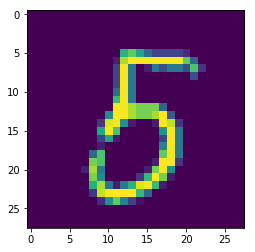

In [37]:
plt.imshow(x_test[45])
plt.show()